# Smartphone-Based Recognition of Human Activities and Postural Transitions Data Set 


## *Project réalisé par Nathan Amar & Ruben Amar*

#### Objectif du projet
Les expériences ont été réalisées avec un groupe de 30 volontaires dans une tranche d'âge de 19-48 ans. Ils ont effectué un protocole d'activités composé de six activités de base : trois postures statiques (debout, assis, couché) et trois activités dynamiques (marche, marche en bas et marche en haut). L'expérience comprenait également des transitions posturales qui se produisaient entre les postures statiques. Il s'agit de la position debout à la position assise, de la position assise à la position debout, de la position assise à la position couchée, de la position debout à la position couchée et de la position couchée à la position debout. Tous les participants portaient un téléphone intelligent (Samsung Galaxy S II) à la taille pendant l'exécution de l'expérience. Nous avons capturé l'accélération linéaire triaxiale et la vitesse angulaire triaxiale à un taux constant de 50Hz en utilisant l'accéléromètre et le gyroscope intégrés à l'appareil. Les expériences ont été enregistrées sur vidéo pour étiqueter les données manuellement. L'ensemble de données obtenu a été divisé au hasard en deux ensembles, où 70 % des volontaires ont été sélectionnés pour générer les données d'entraînement et 30 % les données d'essai.


L'objectif est donc de prédire l'activité de la personne.





### Importation des bibliotheques

In [1]:
import pandas as pd

import numpy as np
from numpy import pi

from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

from collections import Counter
from cycler import cycler
from scipy.stats import norm, skew, probplot
from scipy.optimize import curve_fit

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
!pip install scikit-plot
import scikitplot as skplt
from lightgbm import LGBMClassifier
from time import time

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


/Users/nathanamar/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



### Importation du dataset

Nous avons commencé par transformer nos datasets en fichiers DataFrames. Mais ensuite nous avons trouvé plus simple de combiner manuellement sur Excel ces fichiers text afin d'avoir nos train et test files dans des csv directement. Nous les avons ensuite transformé en DataFrames.

In [2]:
train_X = pd.read_csv('https://raw.githubusercontent.com/Nath19/HAPT_Project_Python_Data_Analysis/master/dataset/Train/X_train.txt', delim_whitespace=True,header=None)
train_y = pd.read_csv('https://raw.githubusercontent.com/Nath19/HAPT_Project_Python_Data_Analysis/master/dataset/Train/y_train.txt',delim_whitespace=True,header=None)
test_X = pd.read_csv('https://raw.githubusercontent.com/Nath19/HAPT_Project_Python_Data_Analysis/master/dataset/Test/X_test.txt', delim_whitespace=True,header=None)
test_y = pd.read_csv('https://raw.githubusercontent.com/Nath19/HAPT_Project_Python_Data_Analysis/master/dataset/Test/y_test.txt', delim_whitespace=True,header=None)

In [3]:

train_df = pd.read_csv('https://raw.githubusercontent.com/Nath19/HAPT_Project_Python_Data_Analysis/master/dataset/New_Data/Train.csv', delimiter=';')
test_df = pd.read_csv('https://raw.githubusercontent.com/Nath19/HAPT_Project_Python_Data_Analysis/master/dataset/New_Data/Test.csv', delimiter=';')

### Analysons notre dataset

On constate ici que notre jeu de données contient énormément de colonnes à analyser.

In [4]:
train_df.shape

(7767, 563)

In [5]:
train_df.head()

,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,fBodyGyroJerkMag-Kurtosis-1,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1,subject,Activity
0,0.043580,-0.005970,-0.035054,-0.995381,-0.988366,-0.937382,-0.995007,-0.988816,-0.953325,-0.794796,...,-0.713308,-0.112754,0.030400,-0.464761,-0.018446,-0.841559,0.179913,-0.051718,1,5
1,0.039480,-0.002131,-0.029067,-0.998348,-0.982945,-0.971273,-0.998702,-0.983315,-0.974000,-0.802537,...,-0.860677,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436,1,5
2,0.039978,-0.005153,-0.022651,-0.995482,-0.977314,-0.984760,-0.996415,-0.975835,-0.985973,-0.798477,...,-0.761847,-0.118559,0.177899,0.100699,0.808529,-0.849230,0.180610,-0.042271,1,5
3,0.039785,-0.011809,-0.028916,-0.996194,-0.988569,-0.993256,-0.996994,-0.988526,-0.993135,-0.798477,...,-0.491604,-0.036788,-0.012892,0.640011,-0.485366,-0.848947,0.181907,-0.040826,1,5
4,0.038758,-0.002289,-0.023863,-0.998241,-0.986774,-0.993115,-0.998216,-0.986479,-0.993825,-0.801982,...,-0.702490,0.123320,0.122542,0.693578,-0.615971,-0.848164,0.185124,-0.037080,1,5


In [6]:
train_df.describe()

,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,fBodyGyroJerkMag-Kurtosis-1,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1,subject,Activity
count,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,...,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000
mean,0.038759,-0.000647,-0.018155,-0.599017,-0.634424,-0.691270,-0.623886,-0.657884,-0.740154,-0.360200,...,-0.625132,0.016774,0.018471,0.009239,-0.005184,-0.485936,0.050310,-0.052888,17.400154,3.934595
std,0.101996,0.099974,0.089927,0.441481,0.367558,0.321641,0.418113,0.348005,0.272619,0.499259,...,0.302581,0.331326,0.443540,0.601208,0.477218,0.509278,0.300866,0.276196,8.968729,2.160171
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.987874,1.000000,1.000000
25%,0.032037,-0.011209,-0.028448,-0.992140,-0.983570,-0.984661,-0.992902,-0.984131,-0.986661,-0.795613,...,-0.843966,-0.108225,-0.261002,-0.470267,-0.373565,-0.810953,-0.047752,-0.140560,8.000000,2.000000
50%,0.038975,-0.002921,-0.019602,-0.914202,-0.827970,-0.827696,-0.924421,-0.838559,-0.852735,-0.717007,...,-0.710071,0.017627,0.029079,0.001515,-0.005503,-0.706619,0.176777,0.004583,19.000000,4.000000
75%,0.044000,0.004303,-0.011676,-0.246026,-0.313069,-0.450478,-0.294903,-0.362671,-0.540521,0.054178,...,-0.503837,0.167695,0.314876,0.496871,0.352690,-0.488765,0.246834,0.109507,26.000000,5.000000
max,1.000000,1.000000,1.000000,1.000000,0.945956,1.000000,1.000000,0.960341,1.000000,1.000000,...,0.911653,1.000000,1.000000,0.998702,0.991288,1.000000,0.482229,1.000000,30.000000,12.000000


In [7]:
test_df.shape

(3162, 563)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7767 entries, 0 to 7766
Columns: 563 entries, tBodyAcc-Mean-1                 to Activity
dtypes: float64(561), int64(2)
memory usage: 33.4 MB


In [9]:
list(train_df.columns)

['tBodyAcc-Mean-1                ',
 'tBodyAcc-Mean-2                ',
 'tBodyAcc-Mean-3                ',
 'tBodyAcc-STD-1                 ',
 'tBodyAcc-STD-2                 ',
 'tBodyAcc-STD-3                 ',
 'tBodyAcc-Mad-1                 ',
 'tBodyAcc-Mad-2                 ',
 'tBodyAcc-Mad-3                 ',
 'tBodyAcc-Max-1                 ',
 'tBodyAcc-Max-2                 ',
 'tBodyAcc-Max-3                 ',
 'tBodyAcc-Min-1                 ',
 'tBodyAcc-Min-2                 ',
 'tBodyAcc-Min-3                 ',
 'tBodyAcc-SMA-1                 ',
 'tBodyAcc-Energy-1              ',
 'tBodyAcc-Energy-2              ',
 'tBodyAcc-Energy-3              ',
 'tBodyAcc-IQR-1                 ',
 'tBodyAcc-IQR-2                 ',
 'tBodyAcc-IQR-3                 ',
 'tBodyAcc-ropy-1                ',
 'tBodyAcc-ropy-1                .1',
 'tBodyAcc-ropy-1                .2',
 'tBodyAcc-ARCoeff-1             ',
 'tBodyAcc-ARCoeff-2             ',
 'tBodyAcc-ARCoeff-3    

Nous avons créé une copie car nous allons faire quelques modification sur le dataset. Par exemple ici nous allons crée un dictionnaire avec les noms des 12 differentes activitées.

In [10]:
train_copy = train_df.copy()
test_copy  =test_df.copy()

In [11]:
remplacements_activity = {
    
    'Activity': {
                  1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', # 3 dynamic activities
        4: 'SITTING', 5: 'STANDING', 6: 'LIYING', # 3 static activities
        
        7: 'STAND_TO_SIT',  8: 'SIT_TO_STAND',  9: 'SIT_TO_LIE', 10: 'LIE_TO_SIT', 
    11: 'STAND_TO_LIE', 12: 'LIE_TO_STAND',# 6 postural Transitions
            }
}

In [12]:
train_copy.replace(remplacements_activity,inplace=True)

In [13]:
test_copy.replace(remplacements_activity,inplace=True)

In [14]:
train_copy.head()

,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,fBodyGyroJerkMag-Kurtosis-1,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1,subject,Activity
0,0.043580,-0.005970,-0.035054,-0.995381,-0.988366,-0.937382,-0.995007,-0.988816,-0.953325,-0.794796,...,-0.713308,-0.112754,0.030400,-0.464761,-0.018446,-0.841559,0.179913,-0.051718,1,STANDING
1,0.039480,-0.002131,-0.029067,-0.998348,-0.982945,-0.971273,-0.998702,-0.983315,-0.974000,-0.802537,...,-0.860677,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436,1,STANDING
2,0.039978,-0.005153,-0.022651,-0.995482,-0.977314,-0.984760,-0.996415,-0.975835,-0.985973,-0.798477,...,-0.761847,-0.118559,0.177899,0.100699,0.808529,-0.849230,0.180610,-0.042271,1,STANDING
3,0.039785,-0.011809,-0.028916,-0.996194,-0.988569,-0.993256,-0.996994,-0.988526,-0.993135,-0.798477,...,-0.491604,-0.036788,-0.012892,0.640011,-0.485366,-0.848947,0.181907,-0.040826,1,STANDING
4,0.038758,-0.002289,-0.023863,-0.998241,-0.986774,-0.993115,-0.998216,-0.986479,-0.993825,-0.801982,...,-0.702490,0.123320,0.122542,0.693578,-0.615971,-0.848164,0.185124,-0.037080,1,STANDING


In [15]:
test_copy.head()

,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,fBodyGyroJerkMag-Kurtosis-1,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1,subject,Activity
0,0.030914,-0.008927,0.040382,-0.938504,-0.944626,-0.759334,-0.952398,-0.950281,-0.802483,-0.757099,...,-0.709087,0.006462,0.162920,-0.825886,0.271151,-0.720559,0.276779,-0.051074,2,STANDING
1,0.042548,0.001079,-0.026236,-0.975516,-0.977502,-0.960146,-0.986694,-0.978983,-0.966820,-0.757099,...,-0.600867,-0.083495,0.017500,-0.434375,0.920593,-0.698684,0.281322,-0.076825,2,STANDING
2,0.038297,-0.011660,-0.025643,-0.993922,-0.979215,-0.973030,-0.994298,-0.980535,-0.977508,-0.799005,...,-0.645500,-0.034956,0.202302,0.064103,0.145068,-0.703355,0.280062,-0.072302,2,STANDING
3,0.036205,-0.018148,-0.025240,-0.994845,-0.981534,-0.976175,-0.995169,-0.983020,-0.980785,-0.798401,...,-0.738474,-0.017067,0.154438,0.340134,0.296407,-0.699545,0.284093,-0.070079,2,STANDING
4,0.038034,-0.013437,-0.032899,-0.993955,-0.977493,-0.984290,-0.994006,-0.977354,-0.985899,-0.798401,...,-0.846150,-0.002223,-0.040046,0.736715,-0.118545,-0.692849,0.290701,-0.066849,2,STANDING


### Verifions si nous avons des duplicates

In [16]:
print('Nombre de valeurs dupliqués dans le train: {}'.format(sum(train_df.duplicated())))
print('Nombre de valeurs dupliqués dans le test {}'.format(sum(test_df.duplicated())))

Nombre de valeurs dupliqués dans le train: 0
Nombre de valeurs dupliqués dans le test 0


### Vérifions si nous avons des NaN.null valeurs

In [17]:
print('Nous avons {} NaN/Null valeurs dans le train'.format(train_df.isnull().values.sum()))
print('Nous avons {} NaN/Null valeurs dans le test'.format(test_df.isnull().values.sum()))

Nous avons 0 NaN/Null valeurs dans le train
Nous avons 0 NaN/Null valeurs dans le test


### Regardons les correlations

La corrélation fait référence à la relation et à l'association mutuelles entre les quantités et elle est généralement utilisée pour exprimer une quantité en termes de sa relation avec d'autres quantités. Elle peut être positive (les variables changent dans le même sens), négative (les variables changent dans le sens opposé) ou neutre (pas de corrélation).

Les variables d'un ensemble de données peuvent être liées de nombreuses façons et pour des raisons diverses :

- Ils peuvent dépendre des valeurs d'autres variables
- Ils peuvent être associés les uns aux autres
- Ils peuvent tous deux dépendre d'une variable de type tierce.


*Nous utiliserons la méthode pandas .corr () pour calculer la corrélation*

In [18]:
feature_cols = train_df.columns[: -1]   

correlated_values = train_df[feature_cols].corr()

correlated_values = (correlated_values.stack().to_frame().reset_index()
                    .rename(columns={'level_0': 'Feature_1', 'level_1': 'Feature_2', 0:'Correlations'}))
correlated_values.head()

,Feature_1,Feature_2,Correlations
0,tBodyAcc-Mean-1,tBodyAcc-Mean-1,1.000000
1,tBodyAcc-Mean-1,tBodyAcc-Mean-2,-0.635967
2,tBodyAcc-Mean-1,tBodyAcc-Mean-3,-0.630025
3,tBodyAcc-Mean-1,tBodyAcc-STD-1,0.023420
4,tBodyAcc-Mean-1,tBodyAcc-STD-2,-0.020698


In [19]:
#creation d'une colonne abs_correlation 
correlated_values['abs_correlation'] = correlated_values.Correlations.abs()
correlated_values.head()

,Feature_1,Feature_2,Correlations,abs_correlation
0,tBodyAcc-Mean-1,tBodyAcc-Mean-1,1.000000,1.000000
1,tBodyAcc-Mean-1,tBodyAcc-Mean-2,-0.635967,0.635967
2,tBodyAcc-Mean-1,tBodyAcc-Mean-3,-0.630025,0.630025
3,tBodyAcc-Mean-1,tBodyAcc-STD-1,0.023420,0.023420
4,tBodyAcc-Mean-1,tBodyAcc-STD-2,-0.020698,0.020698


In [20]:
#Choisissons les features les plus corrélées
train_fields = correlated_values.sort_values('Correlations', ascending = False).query('abs_correlation>0.8')
train_fields.sample(5)

,Feature_1,Feature_2,Correlations,abs_correlation
286317,fBodyAccMag-IQR-1,tBodyGyroJerkMag-IQR-1,0.864259,0.864259
52546,tBodyAccJerk-Min-2,fBodyAcc-SMA-1,-0.918791,0.918791
194465,fBodyAccJerk-Mean-3,tBodyAcc-Min-2,-0.839761,0.839761
292589,fBodyAccJerkMag-SMA-1,fBodyAccJerk-STD-3,0.926504,0.926504
152725,fBodyAcc-Mad-1,fBodyGyro-Mean-1,0.909871,0.909871


In [21]:

# Combinaisons des deux dataframes
train_copy['Data'] = 'Train'
test_copy['Data'] = 'Test'
both_df = pd.concat([train_copy, test_copy], axis=0).reset_index(drop=True)
both_df['subject'] = '#' + both_df['subject'].astype(str)

# Création se notre label ( valeur à predire)
label = both_df.pop('Activity')

print('Shape Train:\t{}'.format(train_copy.shape))
print('Shape Test:\t{}\n'.format(test_copy.shape))

train_copy.head()

Shape Train:	(7767, 564)
Shape Test:	(3162, 564)



,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1,subject,Activity,Data
0,0.043580,-0.005970,-0.035054,-0.995381,-0.988366,-0.937382,-0.995007,-0.988816,-0.953325,-0.794796,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841559,0.179913,-0.051718,1,STANDING,Train
1,0.039480,-0.002131,-0.029067,-0.998348,-0.982945,-0.971273,-0.998702,-0.983315,-0.974000,-0.802537,...,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436,1,STANDING,Train
2,0.039978,-0.005153,-0.022651,-0.995482,-0.977314,-0.984760,-0.996415,-0.975835,-0.985973,-0.798477,...,-0.118559,0.177899,0.100699,0.808529,-0.849230,0.180610,-0.042271,1,STANDING,Train
3,0.039785,-0.011809,-0.028916,-0.996194,-0.988569,-0.993256,-0.996994,-0.988526,-0.993135,-0.798477,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848947,0.181907,-0.040826,1,STANDING,Train
4,0.038758,-0.002289,-0.023863,-0.998241,-0.986774,-0.993115,-0.998216,-0.986479,-0.993825,-0.801982,...,0.123320,0.122542,0.693578,-0.615971,-0.848164,0.185124,-0.037080,1,STANDING,Train


In [22]:
print('Null Values In DataFrame: {}\n'.format(both_df.isna().sum().sum()))
both_df.info()

Null Values In DataFrame: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10929 entries, 0 to 10928
Columns: 563 entries, tBodyAcc-Mean-1                 to Data
dtypes: float64(561), object(2)
memory usage: 46.9+ MB


### Analysons notre target

In [23]:
train_copy['Activity'].value_counts()

STANDING              1423
LIYING                1413
SITTING               1293
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     987
STAND_TO_LIE            90
SIT_TO_LIE              75
LIE_TO_SIT              60
LIE_TO_STAND            57
STAND_TO_SIT            47
SIT_TO_STAND            23
Name: Activity, dtype: int64

In [24]:
label_counts = label.value_counts()
n = label_counts.shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]


data = go.Bar(x = label_counts.index,
              y = label_counts,
              marker = dict(color = colors))

layout = go.Layout(title = 'Smartphone Activity Label Distribution',
                   xaxis = dict(title = 'Activity'),
                   yaxis = dict(title = 'Count'))

fig = go.Figure(data=[data], layout=layout)
iplot(fig)

#### Il y a beaucoup de features. Nous allons donc en prendre quelques une pour avoir quelques visualisations pour la distribution des fonctionnalités dans l'espace.


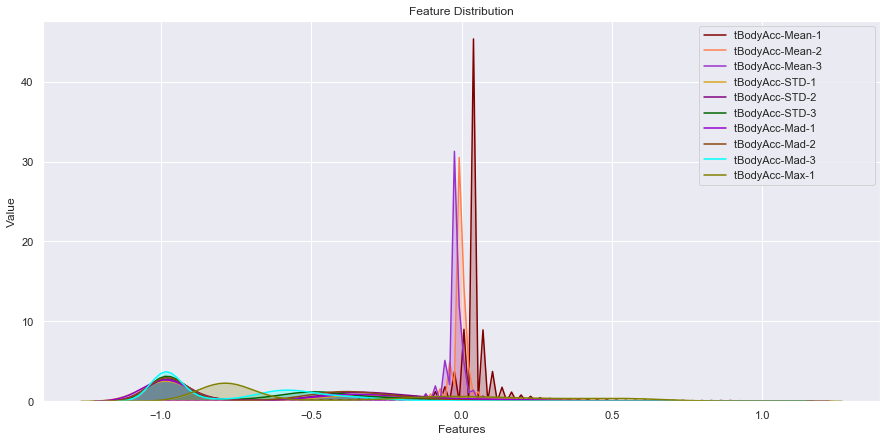

In [25]:
sns.set(rc={'figure.figsize':(15,7)})
colours = ["maroon","coral","darkorchid","goldenrod","purple","darkgreen","darkviolet","saddlebrown","aqua","olive"]
index = -1
for i in train_copy.columns[0:10]:
    index = index + 1
    fig = sns.kdeplot(train_copy[i] , shade=True, color=colours[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig)

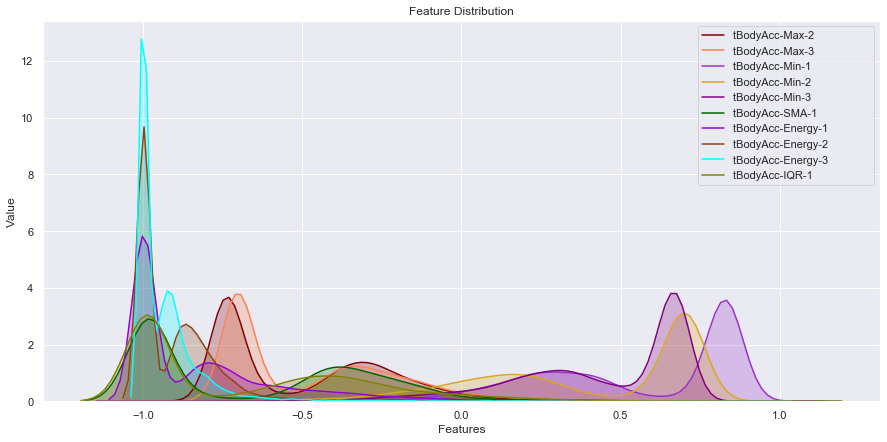

In [26]:
sns.set(rc={'figure.figsize':(15,7)})
colours = ["maroon","coral","darkorchid","goldenrod","purple","darkgreen","darkviolet","saddlebrown","aqua","olive"]
index = -1
for i in train_copy.columns[10:20]:
    index = index + 1
    ax1 = sns.kdeplot(train_copy[i] , shade=True, color=colours[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig)

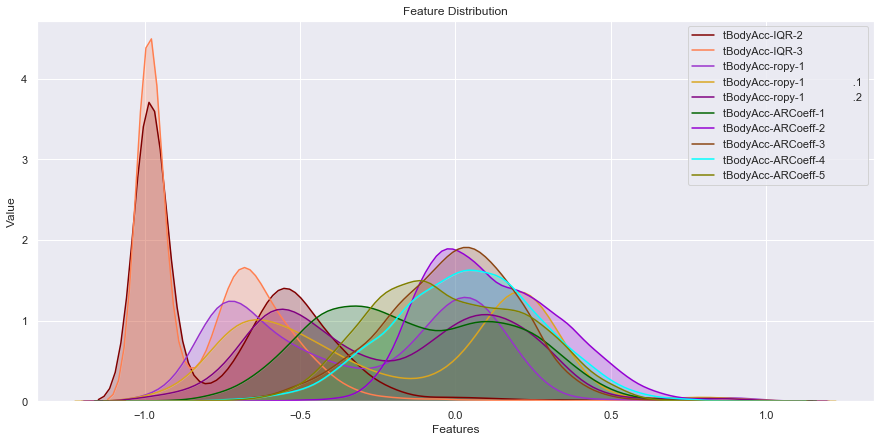

In [27]:
sns.set(rc={'figure.figsize':(15,7)})
colours = ["maroon","coral","darkorchid","goldenrod","purple","darkgreen","darkviolet","saddlebrown","aqua","olive"]
index = -1
for i in train_copy.columns[20:30]:
    index = index + 1
    ax1 = sns.kdeplot(train_copy[i] , shade=True, color=colours[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig)

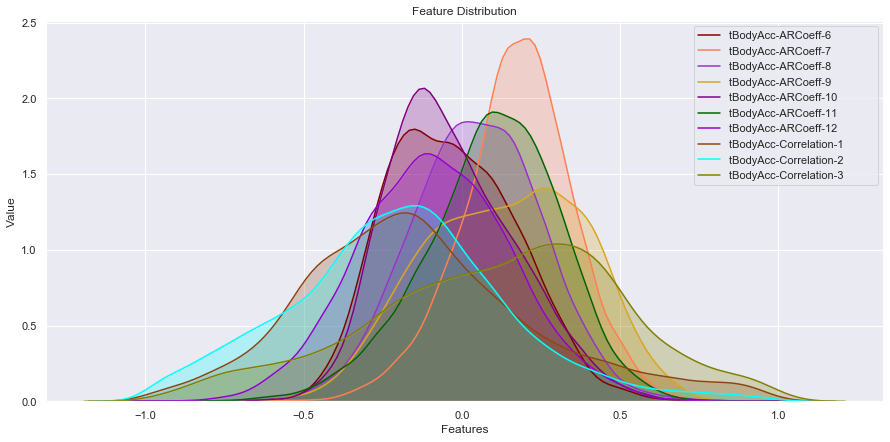

In [28]:
sns.set(rc={'figure.figsize':(15,7)})
colours = ["maroon","coral","darkorchid","goldenrod","purple","darkgreen","darkviolet","saddlebrown","aqua","olive"]
index = -1
for i in train_copy.columns[30:40]:
    index = index + 1
    ax1 = sns.kdeplot(train_copy[i] , shade=True, color=colours[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig)

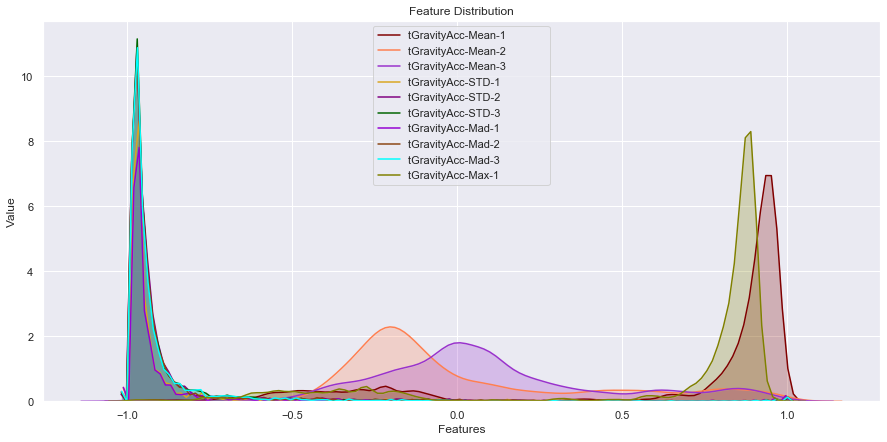

In [29]:
sns.set(rc={'figure.figsize':(15,7)})
colours = ["maroon","coral","darkorchid","goldenrod","purple","darkgreen","darkviolet","saddlebrown","aqua","olive"]
index = -1
for i in train_copy.columns[40:50]:
    index = index + 1
    ax1 = sns.kdeplot(train_copy[i] , shade=True, color=colours[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig)

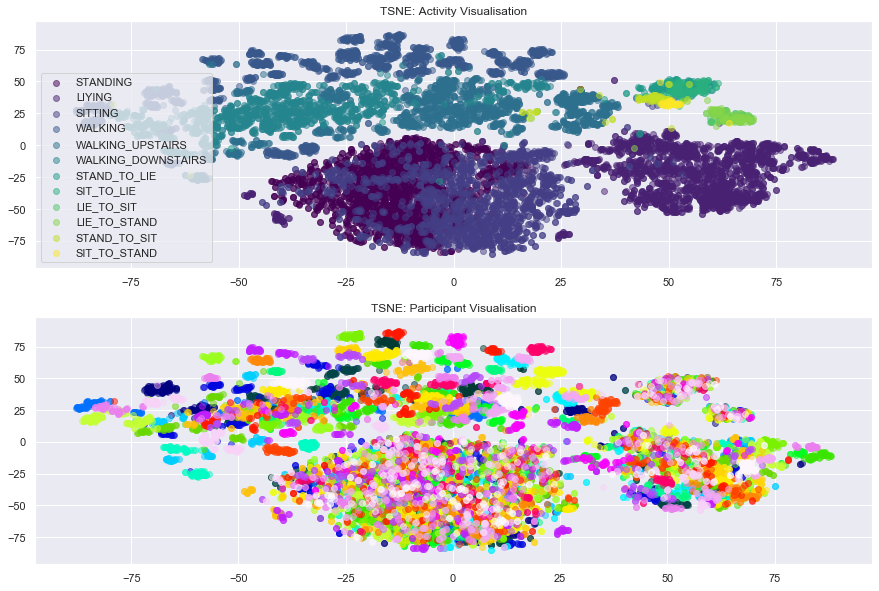

In [30]:
# Create datasets
tsne_data = both_df.copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

#scale dara
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions (speed up)
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)


fig, axarr = plt.subplots(2, 1, figsize=(15,10))


n = label.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (label==group).values
    axarr[0].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr[0].set_title('TSNE: Activity Visualisation')
axarr[0].legend()


n = subject_data.unique().shape[0]
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each participant
for i, group in enumerate(subject_data.unique()):
    # Mask to separate sets
    mask = (subject_data==group).values
    axarr[1].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)

axarr[1].set_title('TSNE: Participant Visualisation')
plt.show()


***On peut bien voir la répartition des différentes activités.***

**Quel capteur est le plus important pour classer les participants par style de marche?**

Adaptons un autre modèle de base aux données de marche et examinons ensuite l'importance des fonctionnalités. Puisqu'il y a tellement de fonctionnalités, je vais les regrouper par leur capteur (accéléromètre = Acc, gyroscope = Gyro)

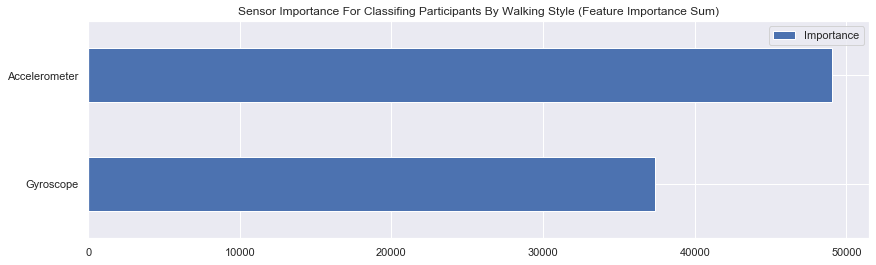

In [31]:
# Create dataset
tsne_data = both_df[label=='WALKING'].copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Split training testing data
enc = LabelEncoder()
label_encoded = enc.fit_transform(subject_data)
X_train, X_test, y_train, y_test = train_test_split(tsne_data, label_encoded, random_state=3)


# Create model
lgbm = LGBMClassifier(n_estimators=500, random_state=3)
lgbm = lgbm.fit(X_train, y_train)

# Get importances with our features importances
features = both_df.drop(['Data', 'subject'], axis=1).columns
importances = lgbm.feature_importances_

# Sum importances
data = {'Gyroscope':0, 'Accelerometer':0}
for importance, feature in zip(importances, features):
    if 'Gyro' in feature:
        data['Gyroscope'] += importance
    if 'Acc' in feature:
        data['Accelerometer'] += importance
        
# Create dataframe and plot
sensor_df = pd.DataFrame.from_dict(data, orient='index').rename(columns={0:'Importance'})
sensor_df.plot(kind='barh', figsize=(14,4), title='Sensor Importance For Classifing Participants By Walking Style (Feature Importance Sum)')
plt.show()

L'accéléromètre fournit un peu plus d'informations. Les deux capteurs sont importants pour la classification et ne pas utiliser les deux capteurs sera un inconvénient pour la qualité du modèle.

## Analyse des participants utilisant les escaliers

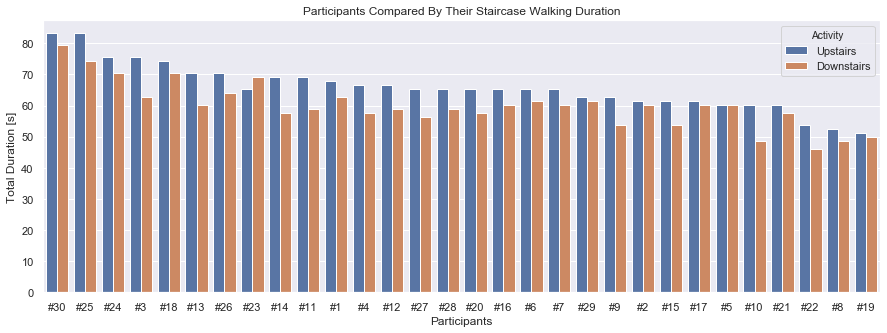

In [32]:
# Group the data by participant and compute total duration of staircase walking
mask = label.isin(['WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])
duration_df = (both_df[mask].groupby([label[mask], 'subject'])['Data'].count() * 1.28)

plot_data = duration_df.reset_index().sort_values('Data', ascending=False)
plot_data['Activity'] = plot_data['Activity'].map({'WALKING_UPSTAIRS':'Upstairs', 'WALKING_DOWNSTAIRS':'Downstairs'})

plt.figure(figsize=(15,5))
sns.barplot(data=plot_data, x='subject', y='Data', hue='Activity')
plt.title('Participants Compared By Their Staircase Walking Duration')
plt.xlabel('Participants')
plt.ylabel('Total Duration [s]')
plt.show()

La majorité des candidats passent plus de temps à monter qu'à descendre les escaliers.Ceci peut s'expliquer avec le schéma qui va suivre qui représente la différence de vitesse entre la montée et la descente des escaliers

#### Ratio Upstairs and DownStair


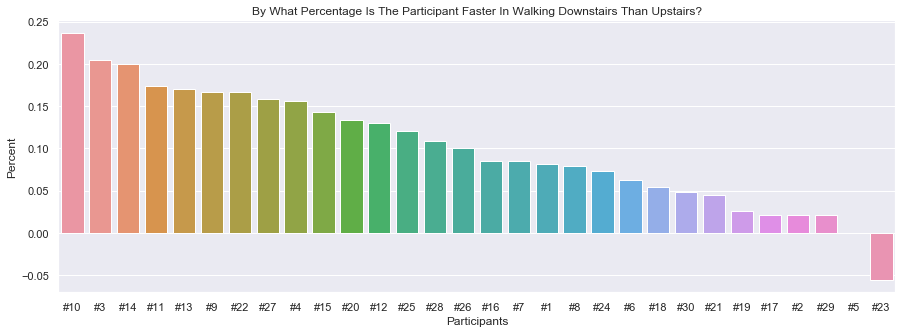

In [33]:

# Create data and plot
plt.figure(figsize=(15,5))
plot_data = ((duration_df.loc['WALKING_UPSTAIRS'] / duration_df.loc['WALKING_DOWNSTAIRS']) -1).sort_values(ascending=False)
sns.barplot(x=plot_data.index, y=plot_data)
plt.title('By What Percentage Is The Participant Faster In Walking Downstairs Than Upstairs?')
plt.xlabel('Participants')
plt.ylabel('Percent')
plt.show()

#On peut voir ici que la plupart des candidats descendent plus rapidement les escaliers qu'ils ne les montent.

#### Les activités stationnaires et mobiles sont complètement différentes

Activités statiques et dynamiques
Dans les activités statiques (assis, debout, allongé), les informations de mouvement ne seront pas très utiles.
Dans les activités dynamiques (Walking, WalkingUpstairs, WalkingDownstairs), les informations de mouvement seront importantes.

/Users/nathanamar/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



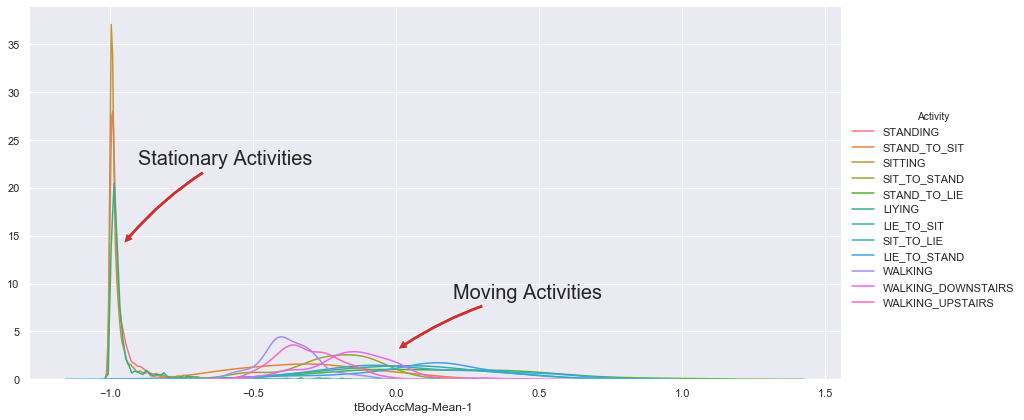

In [34]:
sns.set_palette("Set1", desat=0.80)
facetgrid = sns.FacetGrid(train_copy, hue='Activity', size=6,aspect=2)
facetgrid.map(sns.distplot,'tBodyAccMag-Mean-1             ', hist=False)\
    .add_legend()
plt.annotate("Stationary Activities", xy=(-0.956,14), xytext=(-0.9, 23), size=20,\
            va='center', ha='left',\
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))

plt.annotate("Moving Activities", xy=(0,3), xytext=(0.2, 9), size=20,\
            va='center', ha='left',\
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))
plt.show()


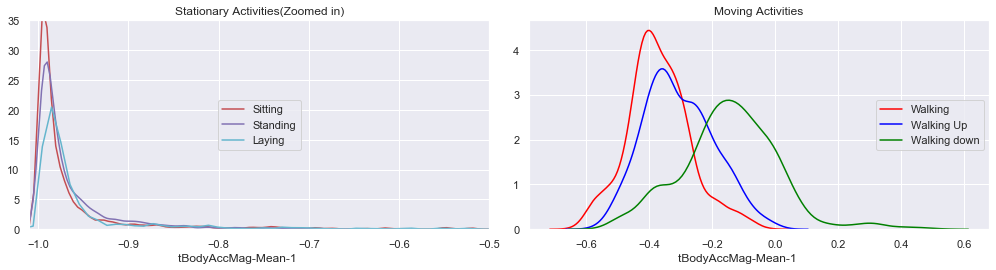

In [35]:
df1 = train_df[train_df['Activity']==1]
df2 = train_df[train_df['Activity']==2]
df3 = train_df[train_df['Activity']==3]
df4 = train_df[train_df['Activity']==4]
df5 = train_df[train_df['Activity']==5]
df6 = train_df[train_df['Activity']==6]


plt.figure(figsize=(14,7))
plt.subplot(2,2,1)
plt.title('Stationary Activities(Zoomed in)')
sns.distplot(df4['tBodyAccMag-Mean-1             '],color = 'r',hist = False, label = 'Sitting')
sns.distplot(df5['tBodyAccMag-Mean-1             '],color = 'm',hist = False,label = 'Standing')
sns.distplot(df6['tBodyAccMag-Mean-1             '],color = 'c',hist = False, label = 'Laying')
plt.axis([-1.01, -0.5, 0, 35])
plt.legend(loc='center')

plt.subplot(2,2,2)
plt.title('Moving Activities')
sns.distplot(df1['tBodyAccMag-Mean-1             '],color = 'red',hist = False, label = 'Walking')
sns.distplot(df2['tBodyAccMag-Mean-1             '],color = 'blue',hist = False,label = 'Walking Up')
sns.distplot(df3['tBodyAccMag-Mean-1             '],color = 'green',hist = False, label = 'Walking down')
plt.legend(loc='center right')


plt.tight_layout()
plt.show()

### L'amplitude d'une accélération peut bien la réduire

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

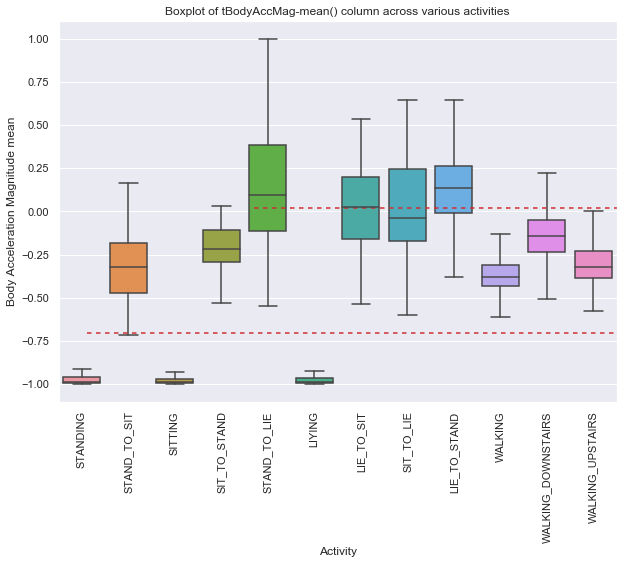

In [36]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Activity', y='tBodyAccMag-Mean-1             ',data=train_copy, showfliers=False)
plt.ylabel('Body Acceleration Magnitude mean')
plt.title("Boxplot of tBodyAccMag-mean() column across various activities")
plt.axhline(y=-0.7, xmin=0.05,dashes=(3,3))
plt.axhline(y=0.020, xmin=0.35, dashes=(3,3))
plt.xticks(rotation=90)



**Observations:**

- Si tAccMean est <-0,8, les activités sont soit debout, soit assis ou couché.
- Si tAccMean est> -0,6, les activités sont soit Walking, WalkingDownstairs ou WalkingUpstairs.
- Si tAccMean> 0.0, l'activité est WalkingDownstairs.
- Nous pouvons classer à 75% les labels d'Activité avec quelques erreurs.

### Existe-t-il un style de marche unique pour chaque participant?

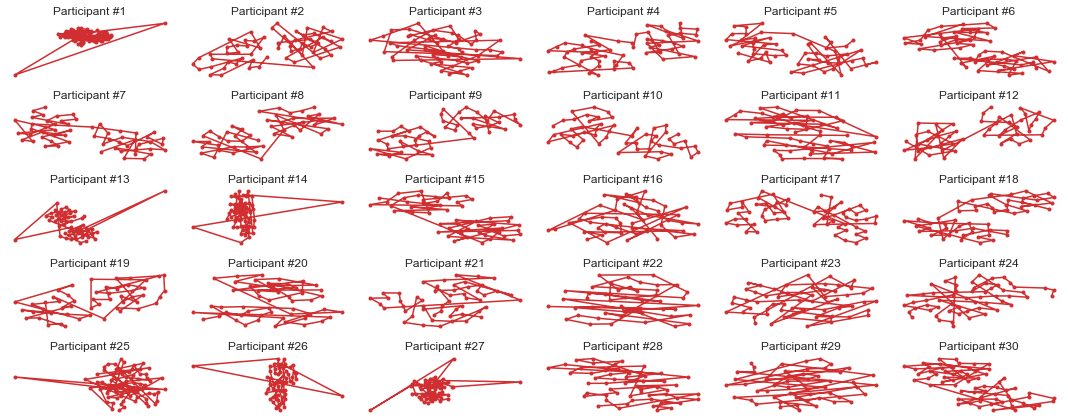

In [37]:
fig, axarr = plt.subplots(5, 6, figsize=(15,6))

for person in range(0, 30):
    # Get data
    single_person = both_df[(label=='WALKING') & (both_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    # Scale data
    scl = StandardScaler()
    tsne_data = scl.fit_transform(single_person)
    # Reduce dimensions
    pca = PCA(n_components=0.9, random_state=3)
    tsne_data = pca.fit_transform(tsne_data)
    # Transform data
    tsne = TSNE(random_state=3)
    tsne_transformed = tsne.fit_transform(tsne_data)
    
    # Create plot
    axarr[person//6][person%6].plot(tsne_transformed[:,0], tsne_transformed[:,1], '.-')
    axarr[person//6][person%6].set_title('Participant #{}'.format(person+1))
    axarr[person//6][person%6].axis('off')
    
plt.tight_layout()
plt.show()

On peut voir que chaque participant marche de facon bien differente, ce qui rend l'experience encore plus interessante.

### Combien de temps le participant marche-t-il?


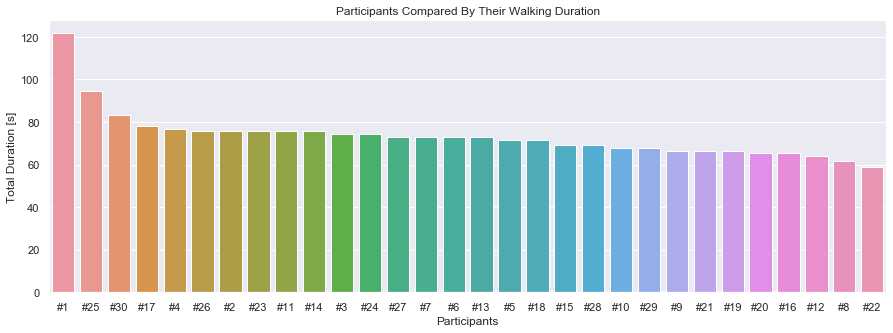

In [38]:
mask = label=='WALKING'
duration_df = (both_df[mask].groupby('subject')['Data'].count() * 1.28)

plot_data = duration_df.reset_index().sort_values('Data', ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(data=plot_data, x='subject', y='Data')
plt.title('Participants Compared By Their Walking Duration')
plt.xlabel('Participants')
plt.ylabel('Total Duration [s]')
plt.show()

## Model

In [39]:
from sklearn. linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [40]:
X_train = train_df.drop(['subject', 'Activity'], axis=1)
y_train = train_df.Activity
X_test = test_df.drop(['subject', 'Activity'], axis=1)
y_test = test_df.Activity
print('Training data size : ', X_train.shape)
print('Test data size : ', X_test.shape)

Training data size :  (7767, 561)
Test data size :  (3162, 561)


#### Decision tree model with Hyperparameter tuning and cross validation

In [41]:
from sklearn.tree import DecisionTreeClassifier
parameters = {'max_depth':np.arange(2,10,2)}
dt_classifier = DecisionTreeClassifier()
dt_classifier_rs = RandomizedSearchCV(dt_classifier,param_distributions=parameters,random_state = 42)
dt_classifier_rs.fit(X_train, y_train)
y_pred = dt_classifier_rs.predict(X_test)

In [42]:
dt_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy using Decision tree : ", dt_accuracy)

Accuracy using Decision tree :  0.8051865907653384


In [43]:
confusion_matrix(y_test, y_pred)

array([[380, 100,  16,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 99, 337,  33,   0,   0,   2,   0,   0,   0,   0,   0,   0],
       [ 27,  76, 317,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 401, 104,   0,   1,   1,   0,   1,   0,   0],
       [  0,   0,   0,  67, 488,   0,   1,   0,   0,   0,   0,   0],
       [  1,   3,   0,   0,   0, 532,   0,   0,   0,   9,   0,   0],
       [  0,   2,   0,   0,   2,   0,  13,   4,   0,   0,   2,   0],
       [  0,   0,   0,   1,   0,   0,   0,   9,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   1,   1,   2,  22,   1,   4,   0],
       [  0,   0,   0,   0,   0,   0,   1,   1,   0,  19,   0,   4],
       [  0,   1,   0,   1,   0,   3,   3,   5,  10,   0,  26,   0],
       [  1,   0,   0,   0,   0,   0,   2,   1,   0,  21,   0,   2]])

Nous allons faire une fonction pour avoir les meilleurs parametres du modele

In [44]:
def get_best_randomsearch_results(model):
    print("Best estimator : ", model.best_estimator_)
    print("Best set of parameters : ", model.best_params_)
    print("Best score : ", model.best_score_)

In [45]:
get_best_randomsearch_results(dt_classifier_rs)

Best estimator :  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Best set of parameters :  {'max_depth': 8}
Best score :  0.8452466724842772


#### Logistic Regression

In [46]:
parameters = {'C':np.arange(10,61,10), 'penalty':['l2','l1']}
lr_classifier = LogisticRegression()
lr_classifier_rs = RandomizedSearchCV(lr_classifier, param_distributions=parameters, cv=5,random_state = 42)
lr_classifier_rs.fit(X_train, y_train)
y_pred = lr_classifier_rs.predict(X_test)

In [47]:
lr_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy using Logistic Regression on test: ", lr_accuracy)

Accuracy using Logistic Regression on test:  0.941808981657179


In [48]:
print( np.unique( y_pred ) ) #Il predit bien 12 classes !

[ 1  2  3  4  5  6  7  8  9 10 11 12]


#### Random forest model with Hyperparameter tuning and cross validation

In [49]:
from sklearn.ensemble import RandomForestClassifier
params = {'n_estimators': np.arange(20,101,10), 'max_depth':np.arange(2,16,2)}
rf_classifier = RandomForestClassifier()
rf_classifier_rs = RandomizedSearchCV(rf_classifier, param_distributions=params,random_state = 42)
rf_classifier_rs.fit(X_train, y_train)
y_pred = rf_classifier_rs.predict(X_test)

In [50]:
rf_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy using Random forest : ", rf_accuracy)

Accuracy using Random forest :  0.9063883617963314


In [51]:
get_best_randomsearch_results(rf_classifier_rs)

Best estimator :  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Best set of parameters :  {'n_estimators': 50, 'max_depth': 14}
Best score :  0.9061439601684288


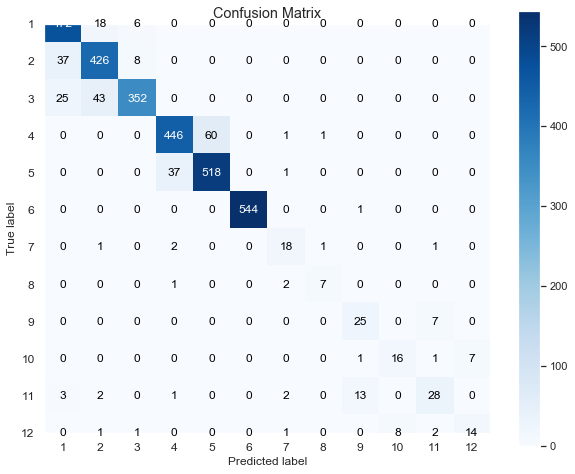

In [52]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(10, 8))
plt.show()

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.88      0.95      0.91       496
           2       0.87      0.90      0.89       471
           3       0.96      0.84      0.89       420
           4       0.92      0.88      0.90       508
           5       0.90      0.93      0.91       556
           6       1.00      1.00      1.00       545
           7       0.72      0.78      0.75        23
           8       0.78      0.70      0.74        10
           9       0.62      0.78      0.69        32
          10       0.67      0.64      0.65        25
          11       0.72      0.57      0.64        49
          12       0.67      0.52      0.58        27

    accuracy                           0.91      3162
   macro avg       0.81      0.79      0.80      3162
weighted avg       0.91      0.91      0.91      3162



#### Linear SVM model with Hyperparameter tuning and cross validation

In [54]:
from sklearn.svm import LinearSVC

In [55]:
parameters = {'C':np.arange(1,12,2)}
lr_svm = LinearSVC(tol=0.00005)
lr_svm_rs = RandomizedSearchCV(lr_svm, param_distributions=parameters,random_state = 42)
lr_svm_rs.fit(X_train, y_train)
y_pred = lr_svm_rs.predict(X_test)

In [56]:
lr_svm_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy using linear SVM : ",lr_svm_accuracy)

Accuracy using linear SVM :  0.9468690702087287


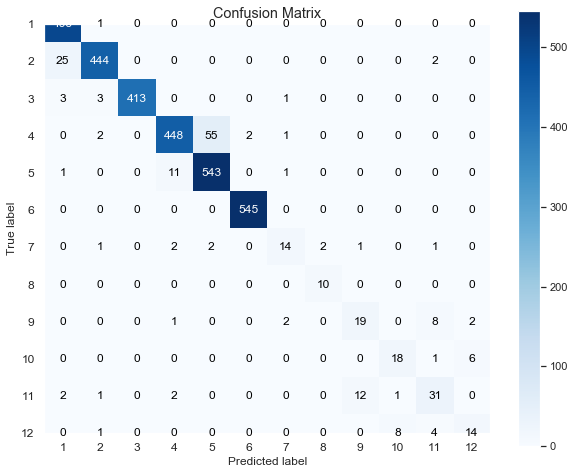

In [57]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(10, 8))
plt.show()

### Comparaison des modèles​

In [58]:
outcome = []
model_names = []
models = [('LogReg', LogisticRegression()), 
          ('SVM', LinearSVC()), 
          ('DecTree', DecisionTreeClassifier()),
          ('RandomForest',RandomForestClassifier())]

In [59]:
from sklearn import model_selection
random_seed = 12

In [60]:
for model_name, model in models:
    k_fold_validation = model_selection.KFold(n_splits=10, random_state=random_seed)
    results = model_selection.cross_val_score(model, X_train, y_train, cv=k_fold_validation, scoring='accuracy')
    outcome.append(results)
    model_names.append(model_name)
    output_message = "%s| Mean=%f STD=%f" % (model_name, results.mean(), results.std())
    print(output_message)

LogReg| Mean=0.925850 STD=0.044568
SVM| Mean=0.936667 STD=0.048333
DecTree| Mean=0.831224 STD=0.047496
RandomForest| Mean=0.907953 STD=0.033814


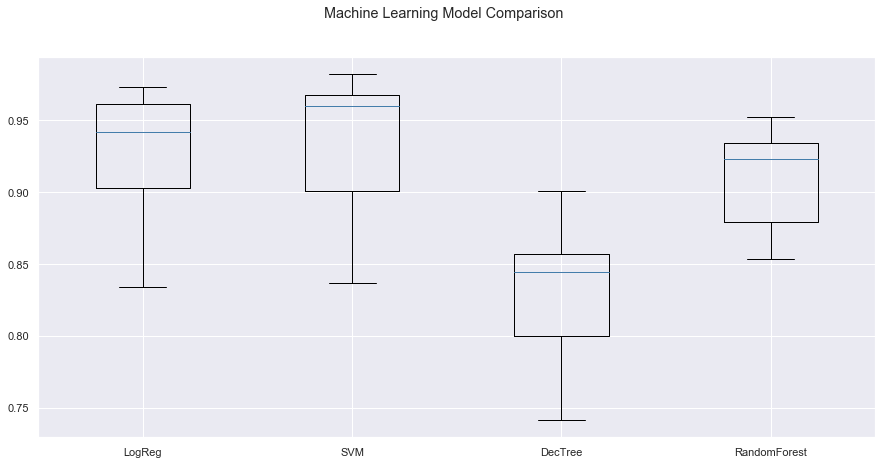

In [61]:
fig = plt.figure()
fig.suptitle('Machine Learning Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(outcome)
ax.set_xticklabels(model_names)
plt.show()

##### Conclusion
Notre meilleur modèle est donc le SVM avec 0.95% d'accuracy

| SVM | Log_Reg| Deci_Tree |Rand_Forest|
| :--------------- :|:---------------:|: -----:| :-----:|
| 0.95 |  0.94       |  0.82          |  0.91|

### FIN.